In [1]:
%matplotlib inline

import os
import numpy as np
from skimage import data, io, filters, transform
from skimage.transform import resize
import pandas as pd
import shutil
import matplotlib
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import load_model
from keras import backend as K
from keras import applications
from keras import optimizers
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# CNN to predict invasive species based on images

Follows mostly the description on:

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [2]:
train_path = '.\\data\\train\\'
test_path = '.\\data\\test\\'

print('# of training files: ' + str(len(os.listdir(train_path))))
print('# of testing files: ' + str(len(os.listdir(test_path))))

# Load train labels in Data Frame
train_labels = pd.read_csv("data/train_labels.csv")

train_labels.head()

# of training files: 2297
# of testing files: 1


,name,invasive
0,1,0
1,2,0
2,3,1
3,4,0
4,5,1


# Show images of invasive class

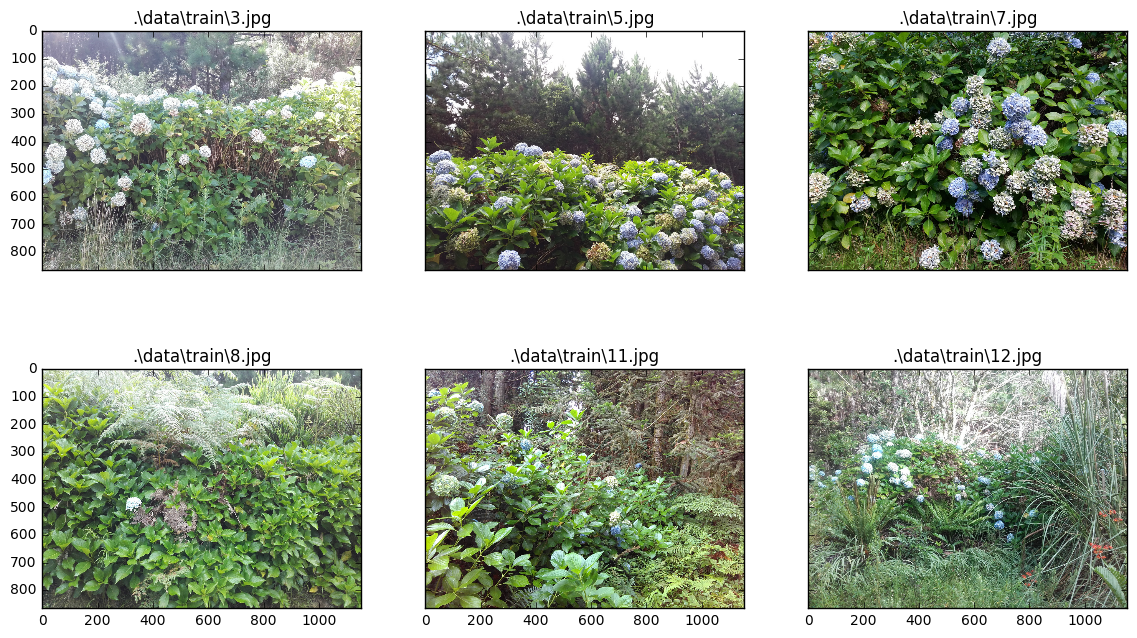

In [3]:
# Show 2x3 images of invasive class
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})

for i in range(0,2):
    for j in range(0,3):
        file_id = train_labels["name"][train_labels["invasive"]==1].iloc[i*3 + j]
        file_name = ".\\data\\train\\" + str(file_id) + ".jpg"
        image = io.imread(file_name)
        axes[i,j].imshow(image)
        axes[i, j].set_title(file_name)

# Show images of non-invasive class

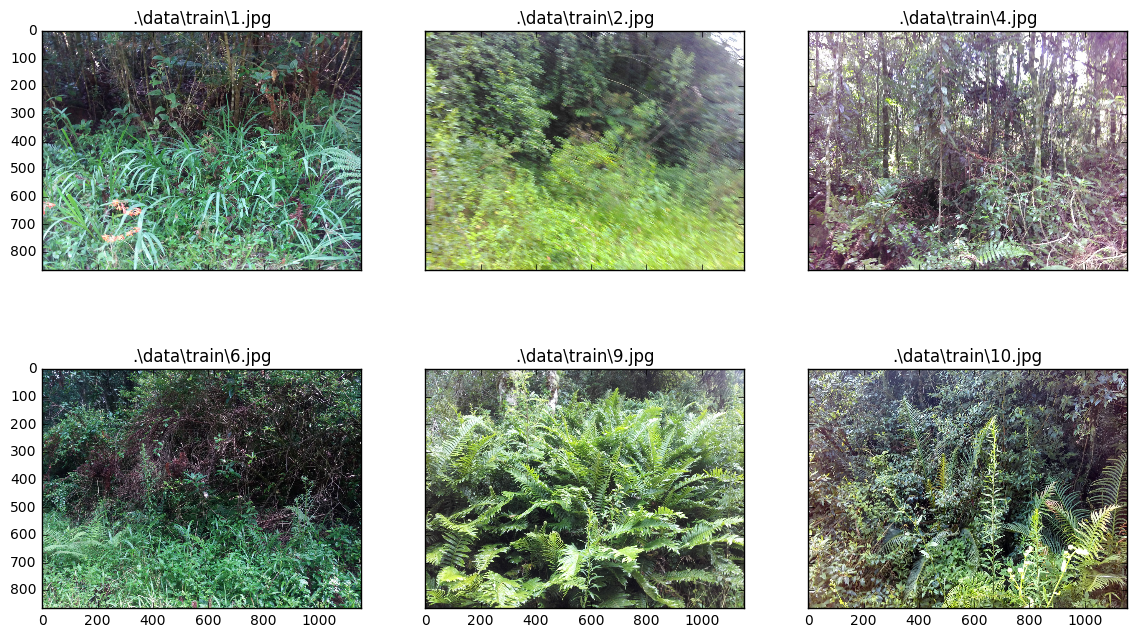

In [4]:
# Show 2x3 images of non-invasive class
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})

for i in range(0,2):
    for j in range(0,3):
        file_id = train_labels["name"][train_labels["invasive"]==0].iloc[i*3 + j]
        file_name = ".\\data\\train\\" + str(file_id) + ".jpg"
        image = io.imread(file_name)
        axes[i,j].imshow(image)
        axes[i, j].set_title(file_name)

# Move data to sub folders (required for Keras)

In [5]:
# Delete subfolders including content
shutil.rmtree(".\\data\\train\\0\\")
shutil.rmtree(".\\data\\train\\1\\")
shutil.rmtree(".\\data\\val\\0\\")
shutil.rmtree(".\\data\\val\\1\\")

# Create them
if not os.path.exists(".\\data\\train\\0\\"):
    os.makedirs(".\\data\\train\\0\\")
    
if not os.path.exists(".\\data\\train\\1\\"):
    os.makedirs(".\\data\\train\\1\\")
    
if not os.path.exists(".\\data\\val\\0\\"):
    os.makedirs(".\\data\\val\\0\\")    
    
if not os.path.exists(".\\data\\val\\1\\"):
    os.makedirs(".\\data\\val\\1\\")    

In [6]:
val_fraction = 0.1

for file_id in range(0, train_labels.shape[0]):
    
    file_name = ".\\data\\train\\" + str(train_labels["name"][file_id]) + ".jpg"
    image = io.imread(file_name)
    
    if train_labels["invasive"][file_id] == 1:
        if np.random.rand() < val_fraction:
            file_name_new = ".\\data\\val\\1\\" + str(train_labels["name"][file_id]) + ".jpg"    
        else:    
            file_name_new = ".\\data\\train\\1\\" + str(train_labels["name"][file_id]) + ".jpg"    
    else:
        if np.random.rand() < val_fraction:
            file_name_new = ".\\data\\val\\0\\" + str(train_labels["name"][file_id]) + ".jpg"        
        else:
            file_name_new = ".\\data\\train\\0\\" + str(train_labels["name"][file_id]) + ".jpg"        
    
    shutil.copy(file_name, file_name_new)

# Prepare data for convolutional network

In [7]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/val',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

# Test generator
test_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=(224, 224),
        batch_size = 1,
        class_mode=None,
        shuffle=False)

Found 2064 images belonging to 2 classes.
Found 231 images belonging to 2 classes.
Found 1531 images belonging to 1 classes.


# Build and convolutional network on top of image net

In [8]:
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

In [9]:
imagenet_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

top_model = Sequential()
top_model.add(Flatten(input_shape=imagenet_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=imagenet_model.input, outputs=top_model(imagenet_model.output))

model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# Fix pretrained layers from imagenet
for layer in model.layers[:16]:
    layer.trainable = False

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [11]:
# Load model which was trained before
model.load_weights('top_model_2017.05.25.h5')

In [12]:
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)
model.save_weights('top_model_2_2017.05.25.h5')

Epoch 1/5
125/125 [==============================] - 4764s - loss: 0.0961 - acc: 0.9685 - val_loss: 0.0214 - val_acc: 1.0000
Epoch 2/5
125/125 [==============================] - 4244s - loss: 0.0865 - acc: 0.9690 - val_loss: 0.0359 - val_acc: 0.9858
Epoch 3/5
125/125 [==============================] - 4249s - loss: 0.0770 - acc: 0.9735 - val_loss: 0.0178 - val_acc: 1.0000
Epoch 4/5
125/125 [==============================] - 4444s - loss: 0.0928 - acc: 0.9630 - val_loss: 0.0295 - val_acc: 0.9922
Epoch 5/5
125/125 [==============================] - 4345s - loss: 0.0722 - acc: 0.9755 - val_loss: 0.0151 - val_acc: 1.0000


# Evaluate

In [13]:
score = model.evaluate_generator(validation_generator, steps = 20)

In [14]:
print(score[1])

1.0


# Predict

In [15]:
test_predictions = model.predict_generator(test_generator, test_generator.n, verbose=1)

1531/1531 [==============================] - 945s   


In [16]:
name = list()
for name_str in test_generator.filenames:
    name_str=name_str[5:-4]
    name.append(int(name_str))

In [19]:
prediction_results = pd.DataFrame(name, columns=["name"])

In [20]:
prediction_results["invasive"] = test_predictions

In [21]:
prediction_results.sort("name", inplace=True)

In [22]:
prediction_results.to_csv("data\\Submission_6_CNN_Pretrained-2017.06.03.csv", index = False)